# ADKF-IFT in Jax

Jax's functional programming style and good support for higher-order derivatives makes implementing ADKF fairly easy.

The goal of this notebook is to walk through a simple 1D toy example.

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

import jax
from jax import random
import jax.numpy as jnp
import optax

# Turn on 64 bit precision for JAX (helps Cholesky)
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from adkf import gp as gp_module
from adkf import ift

In [3]:
import logging
logging.basicConfig(
    level=logging.WARNING, stream=sys.stdout,
    format="%(asctime)s %(name)s %(levelname)s %(message)s",
)
# ift.logger.setLevel(logging.DEBUG)  # uncomment to get more detailed update messages

## Dataset

The meta-dataset will be samples $(x, y)$ where:

$$y=\sin{(e^x)} + 0.2x + \epsilon$$

Although this is best-viewed as samples from a larger dataset rather than a meta-dataset,
we will treat it like a meta-dataset for this example.

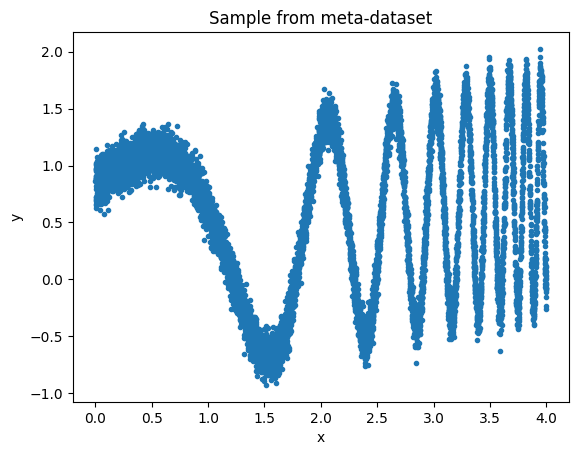

In [4]:
def make_dataset(n):
    x = np.random.random(size=n) * 4
    y = 0.2 * x + np.sin(np.exp(x))
    y += np.random.randn(*y.shape) * 0.1
    return x.reshape(-1, 1), y

x_sample, y_sample = make_dataset(10_000)
plt.plot(x_sample.flatten(), y_sample, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sample from meta-dataset")
plt.show()

## Feature extractor

We will use a very simple, non-linear 1D feature extractor with 4 parameters:

$$z(x) = c_xx + c_{exp}e^x + c_{log}\log{(x+1)} + c_{sqrt}\sqrt{x} $$

Essentially, the feature extractor defines $z$ to be a linear combination of 4 separate non-linear
transforms of x.
Below we implement this feature extractor using `flax` and visualize the effect of parameters $c_*$.
These plots suggest that a good feature extractor will learn a high value of $c_{exp}$,
because this non-linear transformation gives the outputs a very regular lengthscale
which could be fit well by a GP.

In [5]:
import flax.linen as nn
class DummyEncoder(nn.Module):

    def setup(self):
        self.c_x = self.param("c_x", lambda _ : jnp.array(1.0))
        self.c_exp = self.param("c_exp", lambda _ : jnp.array(0.0))
        self.c_log = self.param("c_log", lambda _ : jnp.array(0.0))
        self.c_sqrt = self.param("c_sqrt", lambda _ : jnp.array(0.0))

    def __call__(self, inputs):
        return (
            self.c_x * inputs + 
            self.c_exp * jnp.exp(inputs) + 
            self.c_log * jnp.log(inputs + 1) +
            self.c_sqrt * jnp.sqrt(inputs)
        )

# Initialize model
key1, key2 = random.split(random.PRNGKey(0), 2)
feature_extractor = DummyEncoder()
dummy_input = jnp.array([1.0, 2.0, 3.0]).reshape(-1, 1)
feature_extractor_params = feature_extractor.init(key1, dummy_input)
feature_extractor_params

FrozenDict({
    params: {
        c_x: Array(1., dtype=float64, weak_type=True),
        c_exp: Array(0., dtype=float64, weak_type=True),
        c_log: Array(0., dtype=float64, weak_type=True),
        c_sqrt: Array(0., dtype=float64, weak_type=True),
    },
})

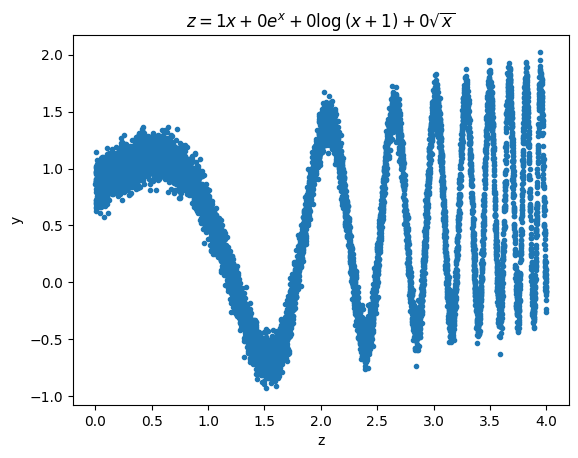

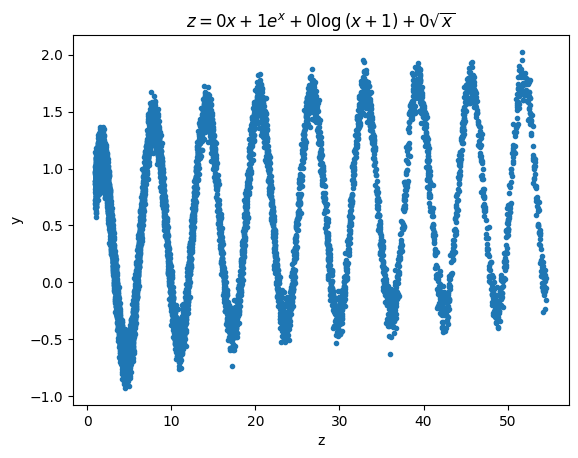

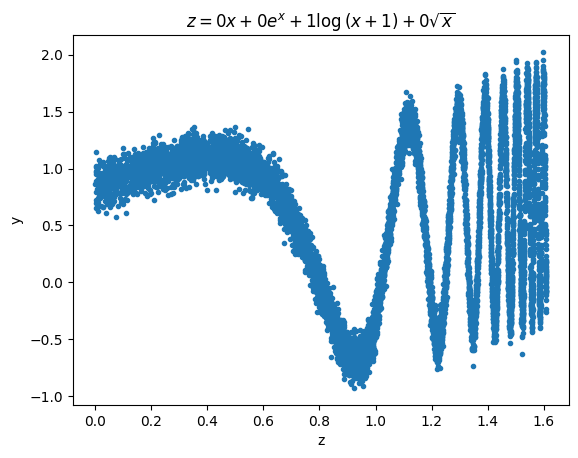

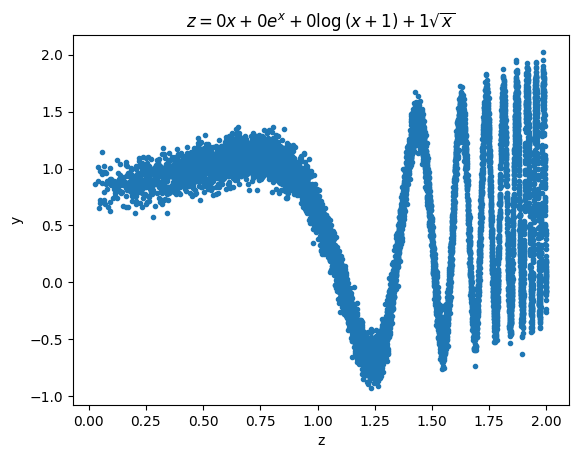

In [6]:
for coeffs in [
    (1, 0, 0, 0),
    (0, 1, 0, 0),
    (0, 0, 1, 0),
    (0, 0, 0, 1),
]:
    params = dict(params=dict(c_x=coeffs[0], c_exp=coeffs[1], c_log=coeffs[2], c_sqrt=coeffs[3]))
    plt.plot(feature_extractor.apply(params, x_sample).flatten(), y_sample, ".")
    plt.ylabel("y")
    plt.xlabel("z")
    plt.title(f"$z={coeffs[0]}x + {coeffs[1]}e^x + {coeffs[2]}\\log{{(x+1)}} + {coeffs[3]}\\sqrt{{x}}$")
    plt.show()

## ADKF training loop 1: meta-learn feature extractor, adapt GP

To run ADKF, you need to define 2 `jax` `pytree` objects (lists/dicts/etc of parameters),
and a function which combines them into a dictionary of all the parameters,
defined in `ift.DeepKernelGPParams` as a `TypedDict`.
We demonstrate this below for "standard" ADKF.

The training logs show that, as expected from the plots above, it learns a high value of $c_{exp}$ and a lower value of the other coefficients.

In [7]:
# The adapt params are the GP params
adapt_params = gp_module.GPParams(raw_amplitude=jnp.array(0.0), raw_noise=jnp.array(-1.0), raw_lengthscale=jnp.array(0.0))

# The meta-learned params are c_* for the feature extractor
meta_params = init_meta_params = dict(params=dict(c_x=jnp.array(1.0), c_exp=jnp.array(0.01), c_log=jnp.array(0.01), c_sqrt=jnp.array(0.01)))

# The function combines the adapt params and meta_params into a dict
def combine_params(adapt_params, meta_params) -> ift.DeepKernelGPParams:
    return dict(
        feature_extractor=meta_params,
        gp=adapt_params,
    )

In [8]:
# Initialize optimizer
meta_params_optimizer = optax.adam(3e-2)  # high learning rate to get quick convergence
opt_state = meta_params_optimizer.init(meta_params)

for step in trange(201):
    
    # Sample train (support) and query (validation) datasets
    x_train, y_train = make_dataset(100)
    x_val, y_val = make_dataset(100)
    
    # Adapt the params with L-BFGS optimizer.
    # Could also use another method, e.g. Adam
    adapted_params = ift.optimize_train_loss_lbfgs(
        adapt_params,
        meta_params,
        param_combine_fn=combine_params,
        x_train=x_train,
        y_train=y_train,
        feature_extractor=feature_extractor,
    )
    
    # Get IFT updates
    pred_loss, meta_grads = ift.ift_gradient_update(
        adapted_params,
        meta_params,
        param_combine_fn=combine_params,
        x_train=x_train,
        y_train=y_train,
        feature_extractor=feature_extractor,
        x_pred=x_val,
        y_pred=y_val,
    )
    
    # Apply updates to meta-params
    updates, opt_state = meta_params_optimizer.update(meta_grads, opt_state)
    meta_params = optax.apply_updates(meta_params, updates)
    
    if step % 25 == 0:
        print(f"Step {step}: pred loss={float(pred_loss):.3g}\n\tmeta_params={meta_params}\n\tadapted_params={adapted_params}\n\n")

  0%|          | 0/201 [00:00<?, ?it/s]

Step 0: pred loss=-58.2
	meta_params={'params': {'c_exp': Array(0.04, dtype=float64), 'c_log': Array(-0.02, dtype=float64), 'c_sqrt': Array(-0.02, dtype=float64), 'c_x': Array(0.97, dtype=float64)}}
	adapted_params=GPParams(raw_amplitude=Array(0.22053258, dtype=float64), raw_noise=Array(-4.33731235, dtype=float64), raw_lengthscale=Array(-2.44908272, dtype=float64))


Step 25: pred loss=-78.8
	meta_params={'params': {'c_exp': Array(0.27098884, dtype=float64), 'c_log': Array(-0.28967368, dtype=float64), 'c_sqrt': Array(-0.15778127, dtype=float64), 'c_x': Array(0.56101467, dtype=float64)}}
	adapted_params=GPParams(raw_amplitude=Array(1.25654625, dtype=float64), raw_noise=Array(-4.53928478, dtype=float64), raw_lengthscale=Array(-0.24056961, dtype=float64))


Step 50: pred loss=-76.6
	meta_params={'params': {'c_exp': Array(0.30172469, dtype=float64), 'c_log': Array(-0.25901726, dtype=float64), 'c_sqrt': Array(-0.03968041, dtype=float64), 'c_x': Array(0.44884461, dtype=float64)}}
	adapted_pa

In [9]:
# Compare initial and final meta-learned params
print(f"Initial: {init_meta_params}")
print(f"Final: {meta_params}")

Initial: {'params': {'c_x': Array(1., dtype=float64, weak_type=True), 'c_exp': Array(0.01, dtype=float64, weak_type=True), 'c_log': Array(0.01, dtype=float64, weak_type=True), 'c_sqrt': Array(0.01, dtype=float64, weak_type=True)}}
Final: {'params': {'c_exp': Array(0.34111094, dtype=float64), 'c_log': Array(-0.08532809, dtype=float64), 'c_sqrt': Array(0.03901142, dtype=float64), 'c_x': Array(0.27418139, dtype=float64)}}


## ADKF training loop 2: a different split

Here we demonstrate a different split of the parameters:

- The GP amplitude, lengthscale, and $c_{log}$ are adapted
- GP noise and $c_{exp}$, $c_sqrt$ are meta-learned
- $c_x$ is fixed at 0.5

This can be done very easily by just changing the form of `adapt_params`, `meta_params`,
and the function to combine them.

In [10]:
adapt_params = dict(
    gp_amp_raw=jnp.array(0.0),
    gp_len_raw=jnp.array(0.0),
    c_log=jnp.array(0.01),
)

meta_params = init_meta_params = dict(c_exp=jnp.array(0.01), gp_noise_raw=jnp.array(-1.0), c_sqrt=jnp.array(0.01))

def combine_params(adapt_params, meta_params):
    return dict(
        
        # GP params: amp and lengthscale are taken from adapt_params,
        # while noise is taken from meta_params
        gp=gp_module.GPParams(
            raw_amplitude=adapt_params["gp_amp_raw"],
            raw_lengthscale=adapt_params["gp_len_raw"],
            raw_noise=meta_params["gp_noise_raw"]
        ),
        
        # Feature extractor: note that c_x is fixed so it is just defined in this function
        feature_extractor=dict(
            params=dict(
                c_log=adapt_params["c_log"],
                c_exp=meta_params["c_exp"],
                c_sqrt=meta_params["c_sqrt"],
                c_x=jnp.array(0.5),
            )
        )
    )

In [11]:
# NOTE: this is the same training loop as above
meta_params_optimizer = optax.adam(3e-2)  # high learning rate to get quick convergence
opt_state = meta_params_optimizer.init(meta_params)

for step in trange(201):
    
    # Sample train (support) and query (validation) datasets
    x_train, y_train = make_dataset(100)
    x_val, y_val = make_dataset(100)
    
    # Adapt the params with L-BFGS optimizer.
    # Could also use another method, e.g. Adam
    adapted_params = ift.optimize_train_loss_lbfgs(
        adapt_params,
        meta_params,
        param_combine_fn=combine_params,
        x_train=x_train,
        y_train=y_train,
        feature_extractor=feature_extractor,
    )
    
    # Get IFT updates
    pred_loss, meta_grads = ift.ift_gradient_update(
        adapted_params,
        meta_params,
        param_combine_fn=combine_params,
        x_train=x_train,
        y_train=y_train,
        feature_extractor=feature_extractor,
        x_pred=x_val,
        y_pred=y_val,
    )
    
    # Apply updates to meta-params
    updates, opt_state = meta_params_optimizer.update(meta_grads, opt_state)
    meta_params = optax.apply_updates(meta_params, updates)
    
    if step % 25 == 0:
        print(f"Step {step}: pred loss={float(pred_loss):.3g}\n\tmeta_params={meta_params}\n\tadapted_params={adapted_params}\n\n")

  0%|          | 0/201 [00:00<?, ?it/s]

Step 0: pred loss=54.2
	meta_params={'c_exp': Array(0.04, dtype=float64), 'c_sqrt': Array(0.04, dtype=float64), 'gp_noise_raw': Array(-1.03, dtype=float64)}
	adapted_params={'c_log': Array(-0.76808438, dtype=float64), 'gp_amp_raw': Array(0.17161245, dtype=float64), 'gp_len_raw': Array(-2.96149498, dtype=float64)}


Step 25: pred loss=13
	meta_params={'c_exp': Array(0.20537292, dtype=float64), 'c_sqrt': Array(0.26915753, dtype=float64), 'gp_noise_raw': Array(-1.78585268, dtype=float64)}
	adapted_params={'c_log': Array(-1.46114198, dtype=float64), 'gp_amp_raw': Array(0.56826262, dtype=float64), 'gp_len_raw': Array(-0.82931678, dtype=float64)}


Step 50: pred loss=-15.2
	meta_params={'c_exp': Array(0.21996917, dtype=float64), 'c_sqrt': Array(0.26955365, dtype=float64), 'gp_noise_raw': Array(-2.54030484, dtype=float64)}
	adapted_params={'c_log': Array(-1.06470108, dtype=float64), 'gp_amp_raw': Array(0.72171426, dtype=float64), 'gp_len_raw': Array(-0.62651265, dtype=float64)}


Step 75: pre

In [12]:
# Compare initial and final meta-learned params
print(f"Initial: {init_meta_params}")
print(f"Final: {meta_params}")

Initial: {'c_exp': Array(0.01, dtype=float64, weak_type=True), 'gp_noise_raw': Array(-1., dtype=float64, weak_type=True), 'c_sqrt': Array(0.01, dtype=float64, weak_type=True)}
Final: {'c_exp': Array(0.35987556, dtype=float64), 'c_sqrt': Array(0.28090306, dtype=float64), 'gp_noise_raw': Array(-4.59782291, dtype=float64)}
